In [1]:
import torch
import numpy as np
from rect_grid import Node, GridStructure
import solve_linear as sl
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import copy
from rect_NN_class import SquareEITNN
from rect_NN_helper import CustomCosineAnnealingWarmRestarts, generate_dtn_data,loss_function,adam_with_grad_clip


This code is just a random test. In this what we do is the following. We take a Dirichlet basis and some random current data and train our model on it and see what happens to the conductivities that we get from it.

In [2]:
n = 4
grid1 = GridStructure(n)
batch_size = 4*n

In [3]:
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please ensure a GPU is available.")
device = torch.device("cuda:0")
print(f"Running on GPU: {torch.cuda.get_device_name(0)}")

Running on GPU: NVIDIA A100-PCIE-40GB


In [4]:
def generate_dtn_data(grid, batch_size):
    """
        for a rectangular grid "grid", of size n by n, we generally generate 4n pairs of DtN data.
        But we can also choose to generate less than 4n pairs of data by using batch_size
        batch_size <= grid.n
    """
    dirichlet = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64)
    neumann = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64)

    for k in range(min(batch_size, 4*grid.n)):            
        dirichlet_data = {idx: 1.0 if idx == grid.boundary_index[k] else 0.0
                          for idx in grid.boundary_index}
        potentials, neumann_data = grid.solve_forward_problem(dirichlet_data)
        dirichlet[k, k] = 1.0
        for j, idx in enumerate(grid.boundary_index):
            neumann[k, j] = neumann_data[idx]

    data = torch.cat((dirichlet, neumann), dim=1)
    return data

In [5]:
data = generate_dtn_data(grid1, batch_size)
# x.shape


In [6]:
M = torch.randn(batch_size, 15, dtype=torch.float64)

# Compute last column so each row sum is 0
last_col = -torch.sum(M, dim=1, keepdim=True)

# Concatenate to form a (16, 16) block with row sums = 0
M_block = torch.cat((M, last_col), dim=1)

# Replace last 32 columns with new 16-column block
data = torch.cat((data[:, :16], M_block), dim=1)

# Check
print(data.shape)  # should be (16, 32)
print(torch.allclose(M_block.sum(dim=1), torch.zeros(batch_size, dtype=torch.float64)))


torch.Size([16, 32])
True


In [7]:
# print(data)


In [8]:
def train_adaptive(device,num_epochs, dataloader, model, alpha, learning_rate, grid, min_lr=1e-10, eta_max=0.08,
                   beta1=0.9, beta2=0.999, eps=1e-8, patience=7500, init_delta_thresh=1e-4, cycle_length=5000):
    model.to(device)
    adam_states = []
    model_grad = [model.W1__grad, model.W2__grad]
    model_param = [model.W1, model.Beta]
    name = ['W1', 'Beta']
    for i, (param, grad) in enumerate(zip(model_param, model_grad)):
        m_t = torch.zeros_like(param).to(device)
        v_t = torch.zeros_like(param).to(device)
        adam_states.append({'name': name[i], 'param': param, 'm': m_t, 'v': v_t, 'param_grad': grad})

    scheduler = CustomCosineAnnealingWarmRestarts(T_0=cycle_length, initial_lr=learning_rate, T_mult=1, eta_min=min_lr, eta_max_factor=eta_max)
    t = 1
    best_loss = float('inf')
    best_lr = learning_rate
    epochs_since_improvement = 0
    beta1_current = beta1
    beta2_current = beta2
    beta_updated = False

    loss_record = []
    interior_loss_record = []
    boundary_loss_record = []

    for epoch in range(num_epochs):
        total_loss_epoch = 0.0
        interior_loss_epoch = 0.0
        boundary_loss_epoch = 0.0
        num_batches = 0

        for batch_x in dataloader:
            batch_x = batch_x.to(device)
            model.zero_grad()
            output, hid = model(batch_x)
            total_loss, interior_loss, boundary_loss = loss_function(device,output, grid, alpha)

            #assign the gradients manually
            model.assign_gradients(batch_x, hid, output, alpha)

            #update the parameters usign the custom adam optimizer

            for state in adam_states:
                param = state['param']
                grad = state['param_grad']
                m = state['m']
                v = state['v']
                new_param, new_m, new_v = adam_with_grad_clip(device,param, grad, learning_rate, m, v, beta1_current, beta2_current, eps, t, max_grad_norm=1.0)
                param.data = new_param.data
                state['m'] = new_m
                state['v'] = new_v
            t += 1
            model.symmetrize_W2_after_training()

            total_loss_epoch += total_loss.item()
            interior_loss_epoch += interior_loss.item()
            boundary_loss_epoch += boundary_loss.item()
            num_batches += 1

        total_loss_epoch /= num_batches
        interior_loss_epoch /= num_batches
        boundary_loss_epoch /= num_batches
        loss_record.append(total_loss_epoch)
        interior_loss_record.append(interior_loss_epoch)
        boundary_loss_record.append(boundary_loss_epoch)

        #update alpha as time goes on...initially we started with a lower alpha to prioritize boundary loss but as we get better loss, we also 
        # give priority to the interior loss


        min_loss = min(interior_loss_epoch, boundary_loss_epoch)
        if min_loss < 1e-9 and alpha < 1.0:
            alpha = 1.0
        elif min_loss < 1e-8 and alpha < 0.9:
            alpha = 0.9
        elif min_loss < 1e-7 and alpha < 0.8:
            alpha = 0.8

        learning_rate = max(scheduler.step(), min_lr)

        #if the base_learning rate becomes too low, reset the base_learning rate andd restart once
        # in case we are stuck in a local minima, this should help us get out of it

        if scheduler.base_lr < 1e-7 and not beta_updated:
            scheduler.reset(new_base_lr=1e-4)
            learning_rate = scheduler.step()
            beta1_current = 0.95
            beta2_current = 0.9999
            beta_updated = True
            print(f"Epoch [{epoch+1}/{num_epochs}], Resetting Base LR to 1e-4, beta1 to {beta1_current}, beta2 to {beta2_current}")

        if total_loss_epoch < best_loss - init_delta_thresh:
            best_loss = total_loss_epoch
            best_lr = learning_rate
            #reduce the delta_threshold as the training loop progresses
            if best_loss > 0:
                order = np.floor(np.log10(best_loss))
                init_delta_thresh = 1e-4 * 10 ** order
            epochs_since_improvement = 0
        elif best_loss == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (best_loss = 0)")
            break
        else:
            epochs_since_improvement += 1

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss_epoch:.6e}, Interior: {interior_loss_epoch:.6e}, Boundary: {boundary_loss_epoch:.6e}, Alpha: {alpha:.4f}, LR: {learning_rate:.6e}, Best LR: {best_lr:.6e}, Base LR: {scheduler.base_lr:.6e}, Cycle: {scheduler.cycle}, T_cur: {scheduler.T_cur}, Delta Thresh: {init_delta_thresh:.6e}, Beta1: {beta1_current:.4f}, Beta2: {beta2_current:.4f}")

        if total_loss_epoch < 1e-12:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (loss < 1e-12)")
            break

        if epochs_since_improvement >= patience:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (no improvement)")
            break

    recovered_gamma = model.W2_dynamic.detach().cpu().numpy()
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]

    original_conductivities = copy.deepcopy(grid.conductivities)
    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")

    demo_grid = GridStructure(grid.n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()

    demo_grid2 = GridStructure(grid.n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()

    plt.plot(loss_record, label="Total Loss")
    plt.plot(interior_loss_record, label="Interior Loss")
    plt.plot(boundary_loss_record, label="Boundary Loss")
    plt.yscale("log")
    plt.legend()
    plt.savefig("loss_plot.png")
    plt.close()

    return loss_record, interior_loss_record, boundary_loss_record, estimated_conductivities

In [9]:
num_epochs = 30000
batch_size = 32
learning_rate = 0.02
alpha = 0.7
cycle_length = 5000

In [10]:
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
model = SquareEITNN(grid1,device)

Epoch [1000/30000], Total Loss: 6.533814e+00, Interior: 2.365398e+00, Boundary: 4.168416e+00, Alpha: 0.7000, LR: 1.809386e-02, Best LR: 1.809386e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-04, Beta1: 0.9000, Beta2: 0.9990
Epoch [2000/30000], Total Loss: 6.021789e+00, Interior: 2.470452e+00, Boundary: 3.551337e+00, Alpha: 0.7000, LR: 1.309614e-02, Best LR: 1.309614e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-04, Beta1: 0.9000, Beta2: 0.9990
Epoch [3000/30000], Total Loss: 5.879568e+00, Interior: 2.442917e+00, Boundary: 3.436651e+00, Alpha: 0.7000, LR: 6.915806e-03, Best LR: 6.921784e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-04, Beta1: 0.9000, Beta2: 0.9990
Epoch [4000/30000], Total Loss: 5.830722e+00, Interior: 2.432898e+00, Boundary: 3.397824e+00, Alpha: 0.7000, LR: 1.913525e-03, Best LR: 1.920924e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-04, Beta1: 0.9000, Be

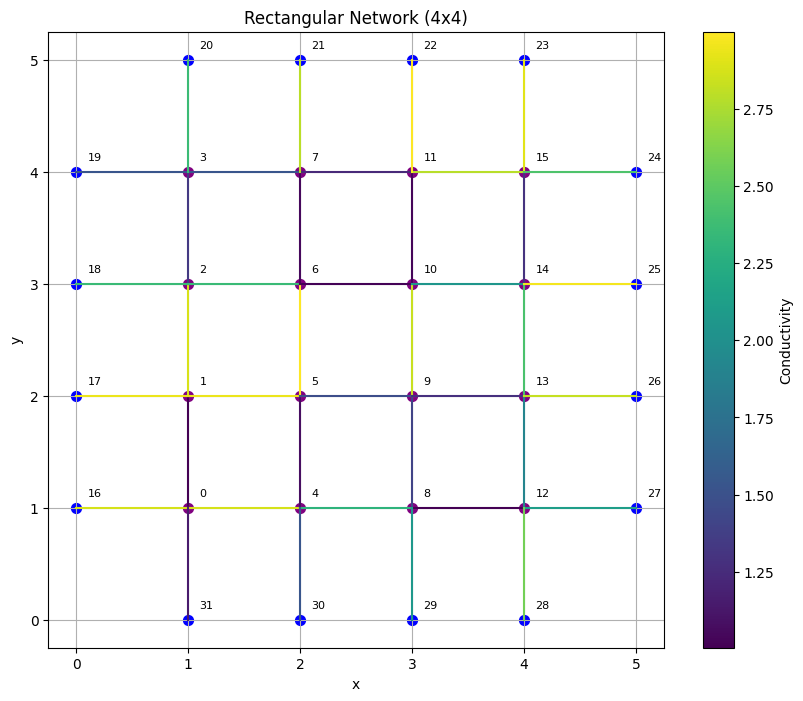

Recovered Conductivity


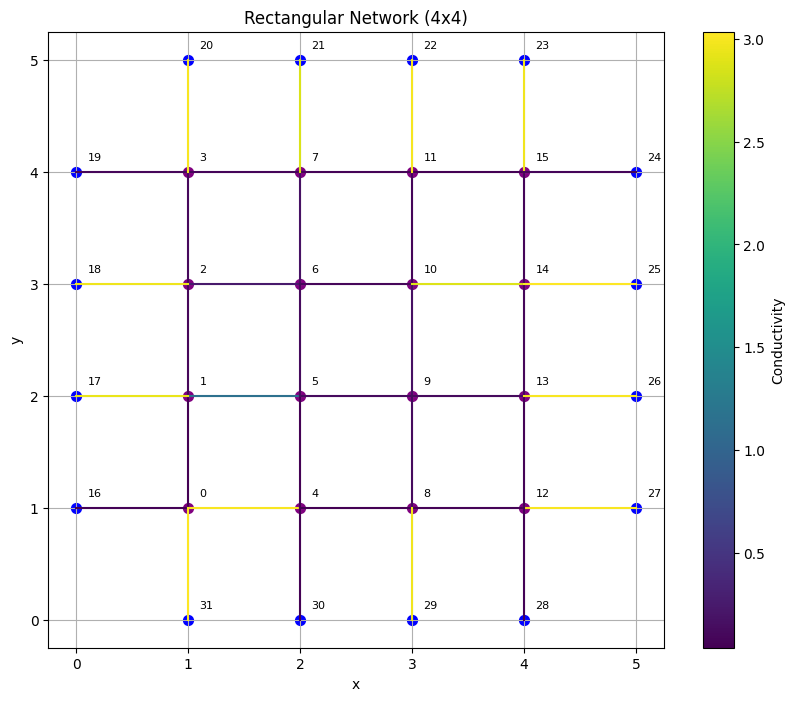

In [11]:
loss_record, interior_loss, boundary_loss, estimated_conductivities = train_adaptive(device,
    num_epochs, dataloader, model, alpha, learning_rate, grid1,
    min_lr=1e-14, eta_max=0.08, beta1=0.9, beta2=0.999, eps=1e-8,
    patience=1.5*cycle_length, init_delta_thresh=1e-4, cycle_length=cycle_length
)

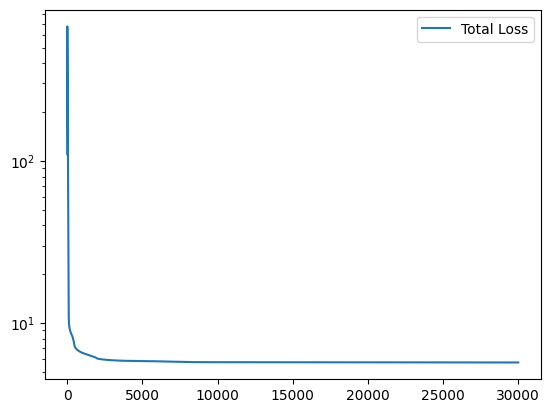

In [12]:
plt.plot(loss_record, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()